In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import warnings
import pandas as pd
from google.colab.patches import cv2_imshow
from sympy.utilities.iterables import cartes

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/CV/data')

#### Additional functions

In [153]:
def get_frame(cap, frame_number):
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if frame_number < 0 or frame_number >= total_frames:
        raise Exception('Incorrect input data, frame number must be in range [0, '+str(int(total_frames-1))+']')
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        _, frame = cap.read()
        return frame

def resize(frame, scale):
  width = int(frame.shape[1] * scale)
  height = int(frame.shape[0] * scale)
  return cv2.resize(frame, (width, height))

def denoise(img):
  kernel = np.ones((5, 5),np.float32)
  img = cv2.filter2D(img, -1, kernel)
  return img

def sv_threshold(hsv_roi, mask, percent):
  mask[hsv_roi[:, :, 1] < 255 * percent] = 0
  mask[hsv_roi[:, :, 2] < 255 * percent] = 0
  return mask

### Preparation of the object model

Notes: 
- the sequence for tracking the object was prepared so that the starting position is at the points (0, 0, width, height).
- since the object is in color, the HSV color model was used.

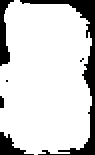

In [223]:
width = 95
height =  155
size = [width, height]
xy = [0, 0]
step = [0, 0]
steps = [-1, 0, 1]
additional_steps = np.tile(steps, (2, 1))
additional_steps = np.asanyarray(list(cartes(additional_steps[0], additional_steps[1])))

cap = cv2.VideoCapture('20220520_212222.mp4')
ret, frame = cap.read()

roi = frame[0:height, 0:width]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi[:, :, 0], 0, 20)

""" Poprawa jakości wykrywania """
mask = sv_threshold(hsv_roi, mask, 0.1)

hist_roi = cv2.calcHist([hsv_roi], [0], mask, [20], [0, 255])
hist_roi = np.ravel(hist_roi / np.sum(hist_roi))

cv2_imshow(mask)
cap.release()
""" Utworzony model obiektu """

### Implementation of the MeanShift algorithm

In [208]:
def mean_var(dst, x, y, width, height, step):
  try:
    mean = np.mean(dst[y+step[1]:y+height+step[1], x+step[0]:x+width+step[0]])
    var = np.var(dst[y+step[1]:y+height+step[1], x+step[0]:x+width+step[0]])
    return mean, var
  except:
    return None, None

def find_step(frame, hist_roi, xy, size, step, additional_steps):
  x, y = xy
  width, height = size
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  dst = cv2.calcBackProject([hsv],[0], hist_roi, [0,255], 1)
  dst = sv_threshold(hsv, dst, 0.1)
  # dst = denoise(dst)
  mean_var_res = []
  for istep in additional_steps:
    mean, var = mean_var(dst, x, y, width, height, istep)
    mean_var_res.append([istep, 1, mean, var])
    if np.all(np.equal(istep, step)):
      for idx in range(2, 30):
        mean, var = mean_var(dst, x, y, width, height, istep*idx)
        mean_var_res.append([istep, idx, mean, var])

  df = pd.DataFrame(mean_var_res, columns=['step', 'coef', 'mean', 'var'])
  df = df.sort_values(by=['mean', 'var'], ascending=[False, True]).reset_index(drop=True)
  new_step, coef = df.iloc[0, :2]
  new_xy = [x, y] + new_step * coef
  return new_xy, new_step

fps = 30
frameSize = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('test.avi', fourcc, fps, frameSize, isColor=True)

width = 95
height =  155
size = [width, height]
xy = [0, 0]
step = [0, 0]
steps = [-1, 0, 1]
additional_steps = np.tile(steps, (2, 1))
additional_steps = np.asanyarray(list(cartes(additional_steps[0], additional_steps[1])))

cap = cv2.VideoCapture('20220520_212222.mp4')
ret, frame = cap.read()

roi = frame[0:height, 0:width]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi[:, :, 0], 0, 20)
mask = sv_threshold(hsv_roi, mask, 0.1)
hist_roi = cv2.calcHist([hsv_roi], [0], mask, [20], [0, 255])

while True:
  ret, frame = cap.read()
  if not ret:
    break
  new_xy, new_step = find_step(frame, hist_roi, xy, size, step, additional_steps)
  xy = copy.deepcopy(new_xy)
  step = copy.deepcopy(new_step)
  frame = cv2.rectangle(frame, (xy[0], xy[1]), (width+xy[0], height+xy[1]), (0, 200, 0), 3)
  out.write(frame)

cap.release()
out.release()

### Implementation of the CamShift algorithm

In [325]:
def mean_var_size(dst, x, y, width, height, idx):
  try:
    mean = np.mean(dst[y:y+int(height*idx), x:x+int(width*idx)])
    var = np.var(dst[y:y+int(height*idx), x:x+int(width*idx)])
    return mean, var
  except:
    return None, None

def find_size(frame, hist_roi, xy, size, step, additional_steps):
  x, y = xy
  width, height = size
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  dst = cv2.calcBackProject([hsv],[0], hist_roi, [0,255], 1)
  dst = sv_threshold(hsv, dst, 0.1)
  res = []
  for idx in np.arange(0.5, 2, 0.05):
    hist = cv2.calcHist([hsv[y:y+int(height*idx), x:x+int(width*idx)]], [0], dst[y:y+int(height*idx), x:x+int(width*idx)], [20], [0, 255])
    dist = np.linalg.norm(hist_roi - hist)
    res.append([idx, dist, np.count_nonzero(dst[y:y+int(height*idx), x:x+int(width*idx)])])
  for jdx in np.arange(-0.5, -2, -0.05):
    idx = jdx * (-1)
    import time
    start = time.time()
    hist = cv2.calcHist([hsv[int(y*idx):y+int(height), int(x*idx):x+int(width)]], [0], dst[hsv[int(y*idx):y+int(height), int(x*idx):x+int(width)]], [20], [0, 255])
    print(time.time() - start)
    dist = np.linalg.norm(hist_roi - hist)
    res.append([jdx, dist, np.count_nonzero(dst[int(y*idx):y+int(height), int(x*idx):x+int(width)])])
  df = pd.DataFrame(res, columns=['coef', 'dist', 'zero'])
  df = df.sort_values(by=['zero', 'dist'], ascending=[False, True]).reset_index(drop=True)
  coef = df.iloc[0, :1]
  if coef[0] > 0:
    new_size = (np.array(size)*coef[0]).astype(np.int64)
    new_xy = xy
  else:
    new_xy = (np.array(xy)*coef[0]*(-1)).astype(np.int64)
    new_size = size
  return new_xy.astype(np.int32), new_size.astype(np.int32)

fps = 30
frameSize = (1920, 1080)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('test.avi', fourcc, fps, frameSize, isColor=True)

width = 95
height =  155
size = [width, height]
xy = [0, 0]
step = [0, 0]
steps = [-1, 0, 1]
additional_steps = np.tile(steps, (2, 1))
additional_steps = np.asanyarray(list(cartes(additional_steps[0], additional_steps[1])))

cap = cv2.VideoCapture('20220520_212222.mp4')
ret, frame = cap.read()

roi = frame[0:height, 0:width]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi[:, :, 0], 0, 20)
mask = sv_threshold(hsv_roi, mask, 0.1)
hist_roi = cv2.calcHist([hsv_roi], [0], mask, [20], [0, 255])

i = 0
while True:
  ret, frame = cap.read()
  print(i)
  i+= 1
  if not ret:
    break
  new_xy, new_step = find_step(frame, hist_roi, xy, size, step, additional_steps)
  xy = copy.deepcopy(new_xy)
  step = copy.deepcopy(new_step)
  new_xy, new_size = find_size(frame, hist_roi, xy, size, step, additional_steps)
  xy = copy.deepcopy(new_xy)
  size = copy.deepcopy(new_size)
  width, height = size
  frame = cv2.rectangle(frame, (int(xy[0]), int(xy[1])), (int(width+xy[0]), int(height+xy[1])), (0, 200, 0), 3)
  out.write(frame)

cap.release()
out.release()

### Algorithm comparison:

#### First frame

Po lewej stronie meanshift, po prawej - camshift


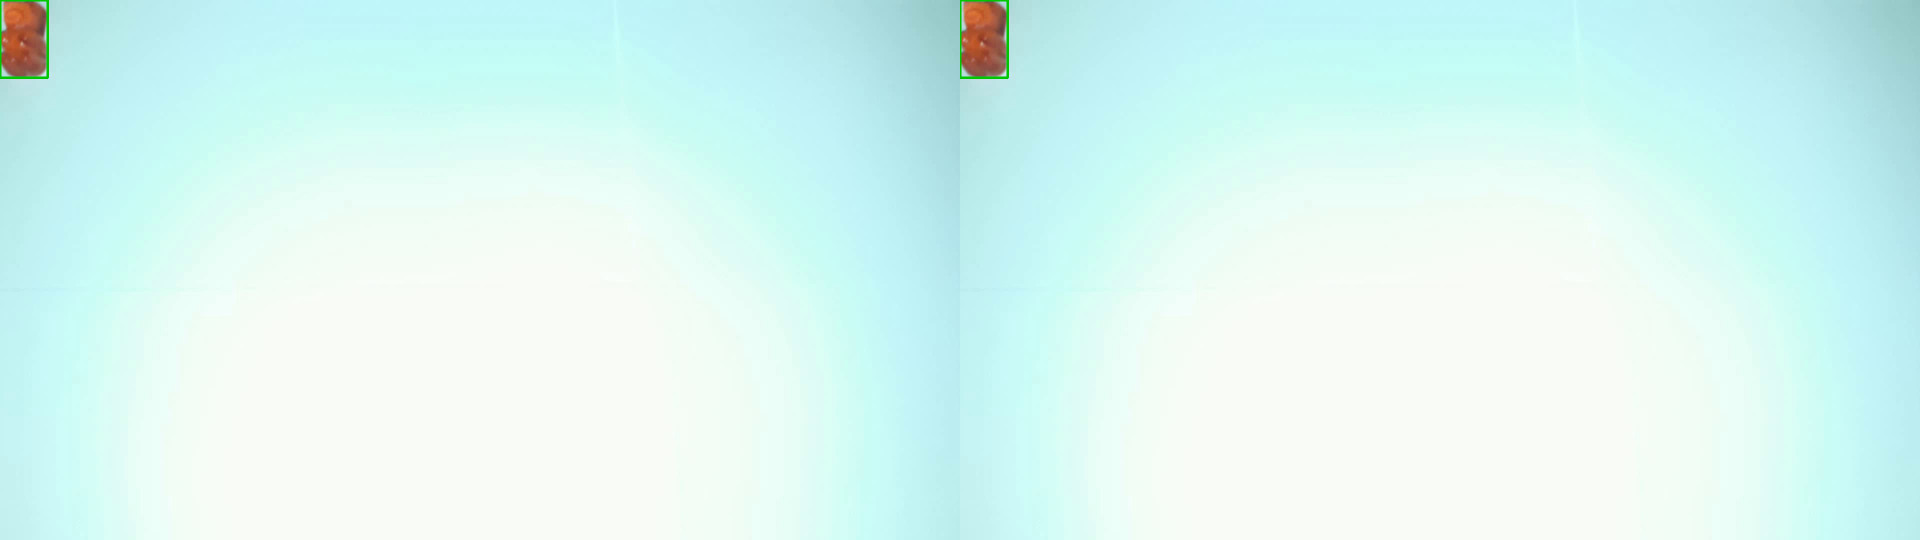

In [357]:
cap_meanshift = cv2.VideoCapture('meanshift.avi')
cap_camshift = cv2.VideoCapture('camshift.avi')

def plot(cap_meanshift, cap_camshift, frame_n):
  print("Po lewej stronie meanshift, po prawej - camshift")
  img_m = get_frame(cap_meanshift, frame_n)
  img_c = get_frame(cap_camshift, frame_n)
  cv2_imshow(resize(np.hstack([img_m, img_c]), 0.5))

plot(cap_meanshift, cap_camshift, 0)

### Tracking an object without changing its size:

Po lewej stronie meanshift, po prawej - camshift


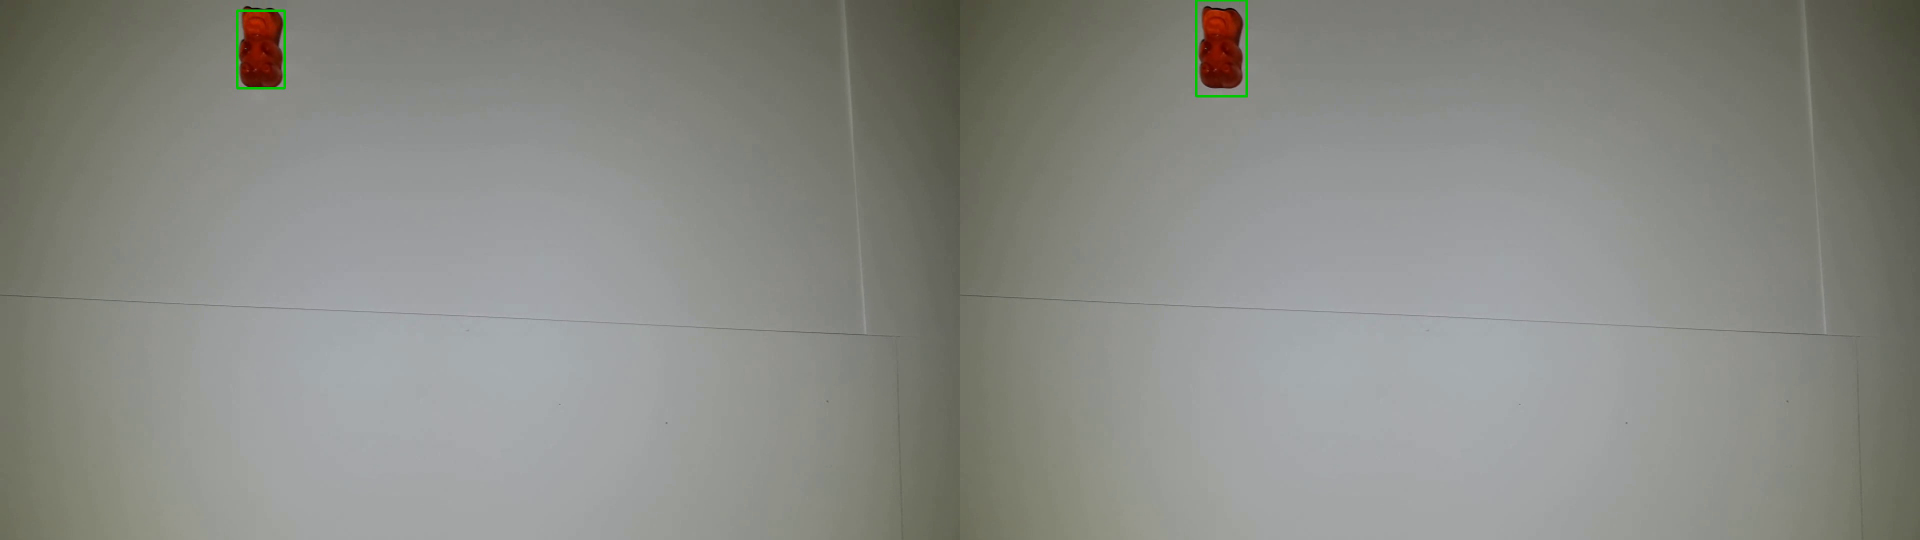

In [354]:
plot(cap_meanshift, cap_camshift, 100)

### Tracking a zooming object

Po lewej stronie meanshift, po prawej - camshift


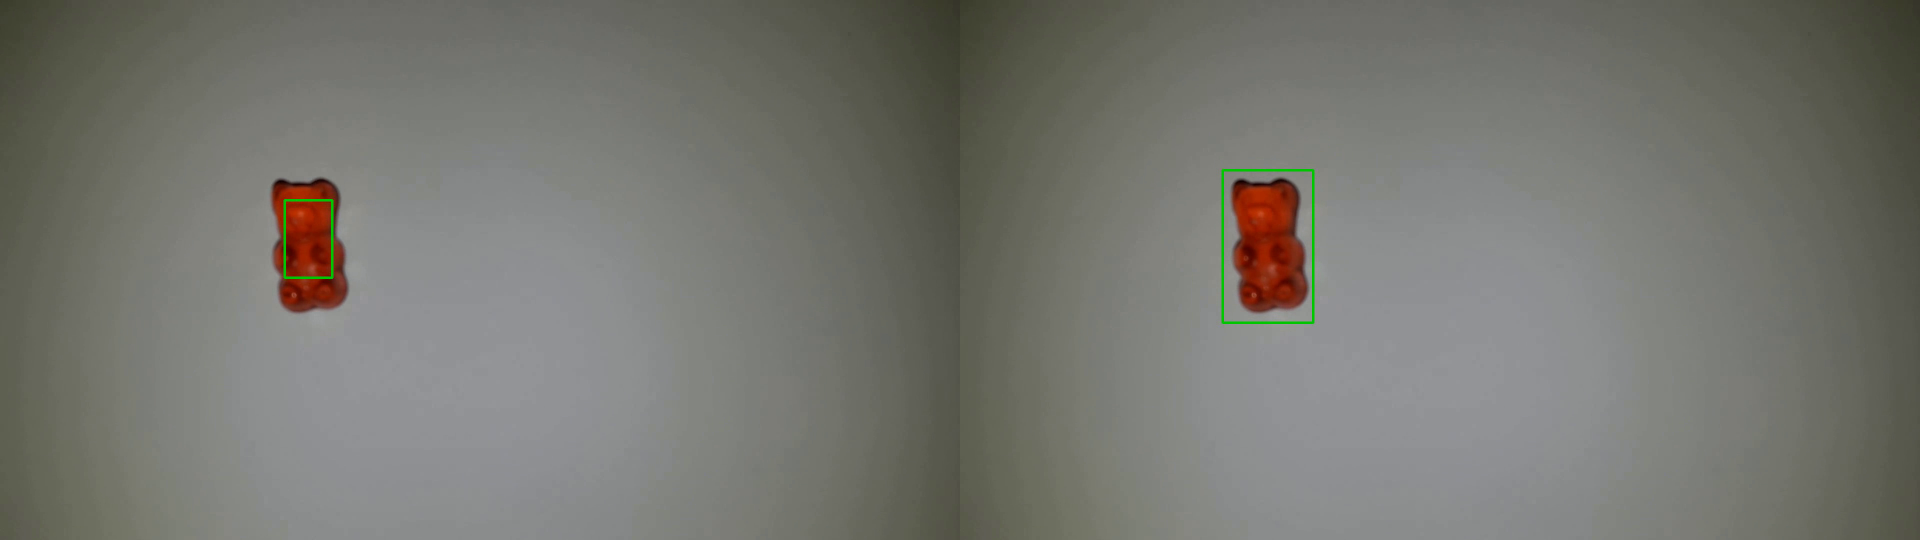

In [355]:
plot(cap_meanshift, cap_camshift, 690)

### Tracking a shrinking object

Po lewej stronie meanshift, po prawej - camshift


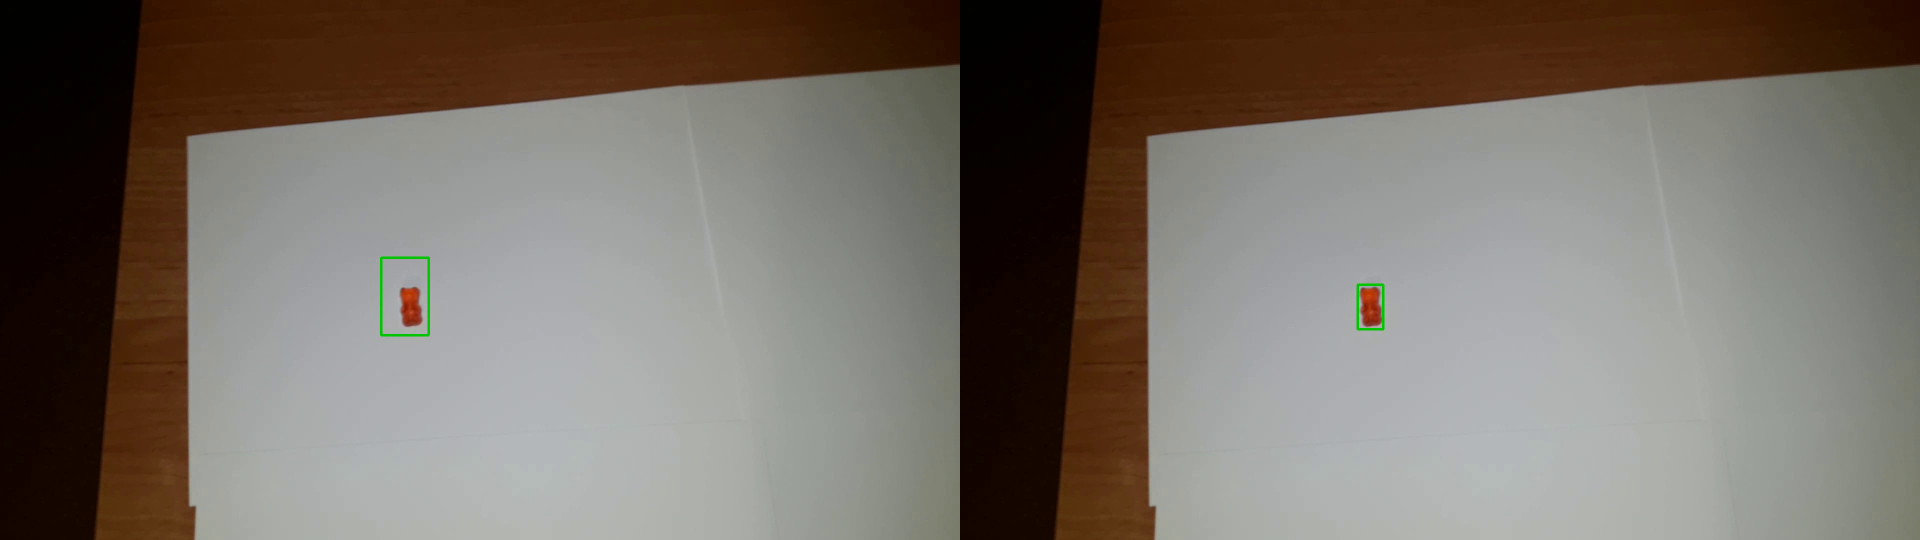

In [356]:
plot(cap_meanshift, cap_camshift, 850)

### Conclusions 
- The HSV color model worked well for creating the object model, although the frames in the sequence were darkened over time. 
- Although the meanshift algorithm did not take into account the size of the object to be tracked, it did not lose it.
- The camshift algorithm is more versatile, although it performs worse time-wise due to longer computation time.